In [230]:
import networkx as nx
import igraph as ig
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
#from curved_edges import curved_edges

from cdlib import algorithms
import community
import leidenalg as lalg
from fa2 import ForceAtlas2
import bezier

#ForceAtlas2 instantiated
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

plt.style.use('ggplot')

In [5]:
'''
Source: https://github.com/beyondbeneath/bezier-curved-edges-networkx/blob/master/curved_edges.py
'''

def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity='random'):
    # Get nodes into np array
    edges = np.array(G.edges())
    l = edges.shape[0]

    if polarity == 'random':
        # Random polarity of curve
        rnd = np.where(np.random.randint(2, size=l)==0, -1, 1)
    else:
        # Create a fixed (hashed) polarity column in the case we use fixed polarity
        # This is useful, e.g., for animations
        rnd = np.where(np.mod(np.vectorize(hash)(edges[:,0])+np.vectorize(hash)(edges[:,1]),2)==0,-1,1)
    
    # Coordinates (x,y) of both nodes for each edge
    # e.g., https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    # Note the np.vectorize method doesn't work for all node position dictionaries for some reason
    u, inv = np.unique(edges, return_inverse = True)
    coords = np.array([pos[x] for x in u])[inv].reshape([edges.shape[0], 2, edges.shape[1]])
    coords_node1 = coords[:,0,:]
    coords_node2 = coords[:,1,:]
    
    # Swap node1/node2 allocations to make sure the directionality works correctly
    should_swap = coords_node1[:,0] > coords_node2[:,0]
    coords_node1[should_swap], coords_node2[should_swap] = coords_node2[should_swap], coords_node1[should_swap]
    
    # Distance for control points
    dist = dist_ratio * np.sqrt(np.sum((coords_node1-coords_node2)**2, axis=1))

    # Gradients of line connecting node & perpendicular
    m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])
    m2 = -1/m1

    # Temporary points along the line which connects two nodes
    # e.g., https://math.stackexchange.com/questions/656500/given-a-point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    t1 = dist/np.sqrt(1+m1**2)
    v1 = np.array([np.ones(l),m1])
    coords_node1_displace = coords_node1 + (v1*t1).T
    coords_node2_displace = coords_node2 - (v1*t1).T

    # Control points, same distance but along perpendicular line
    # rnd gives the 'polarity' to determine which side of the line the curve should arc
    t2 = dist/np.sqrt(1+m2**2)
    v2 = np.array([np.ones(len(edges)),m2])
    coords_node1_ctrl = coords_node1_displace + (rnd*v2*t2).T
    coords_node2_ctrl = coords_node2_displace + (rnd*v2*t2).T

    # Combine all these four (x,y) columns into a 'node matrix'
    node_matrix = np.array([coords_node1, coords_node1_ctrl, coords_node2_ctrl, coords_node2])

    # Create the Bezier curves and store them in a list
    curveplots = []
    for i in range(l):
        nodes = node_matrix[:,i,:].T
        curveplots.append(bezier.Curve(nodes, degree=3).evaluate_multi(np.linspace(0,1,bezier_precision)).T)
      
    # Return an array of these curves
    curves = np.array(curveplots)
    return curves

In [124]:
bezier.curve.from_node?

Object `bezier.curve.from_node` not found.


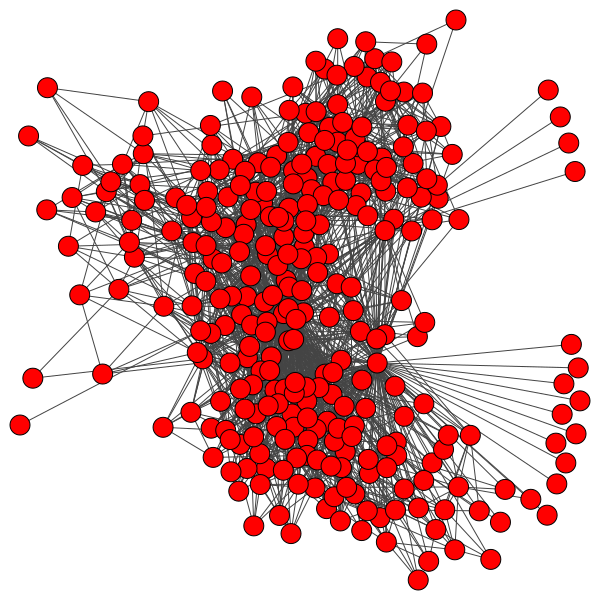

In [2]:
#read data

data = open("out.dimacs10-celegansneural", "rb")
G = nx.read_weighted_edgelist(data,comments='%')
data.close()


#Convert to igraph
iG = ig.Graph.from_networkx(G)
ig.plot(iG)

# METRICS

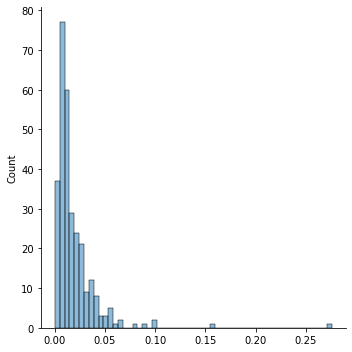

In [3]:
#clustering coefficients
cc = nx.clustering(G, weight='weight')
clust = pd.DataFrame(cc.values(), index = range(len(cc.items())), columns=['clustering coefficient'])

clust
sns.displot(clust,legend=False)

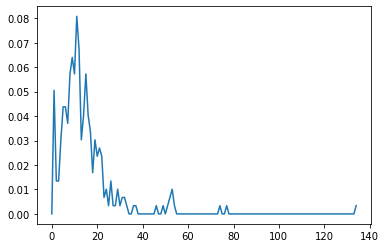

In [4]:
#Degrees

def degree_distribution(G):
    
    deg = dict(G.degree())
    deg = list(deg.values())  
    deg = np.array(deg) 
    
    maxk = np.max(deg)
    k = np.arange(0,maxk+1) #array of the possible degrees
    
    pk = np.zeros(maxk+1) # degree distribution p(k)
    for i in deg:
        pk[i] = pk[i] + 1
    pk = pk/sum(pk) # the sum of the elements of P(k) must to be equal to one
    
    return k,pk

k, pk = degree_distribution(G)

# plt.yscale('log')
# plt.xscale('log')
plt.plot(k,pk)

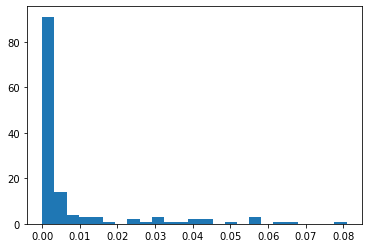

In [5]:
plt.hist(pk,bins=25)
plt.show()

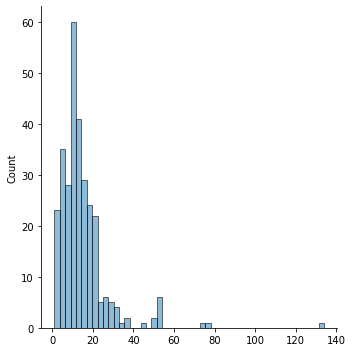

In [6]:
# using sns
deg = dict(G.degree)
deg_df = pd.DataFrame(deg.values(),index = range(len(deg.items())), columns=['Node degrees'])

sns.displot(deg_df,legend=False)

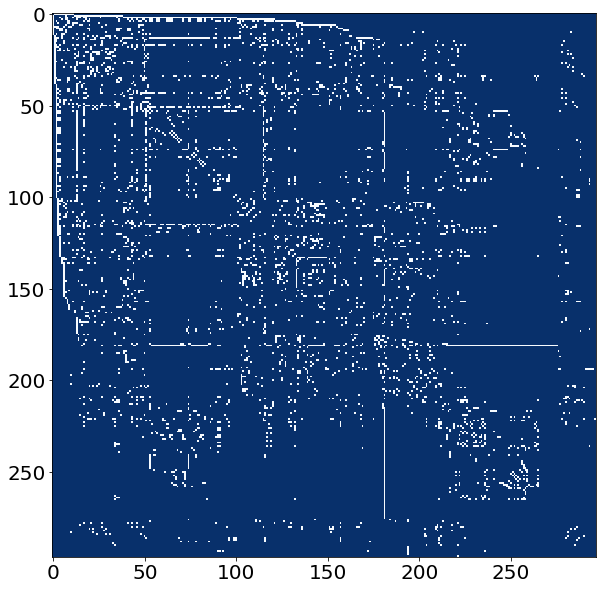

In [15]:
#Adjacency Matrix
cmap = plt.cm.Blues_r
iA = iG.get_adjacency()
iA = np.array(iA.data)

plt.figure(figsize=(10,10))
plt.imshow(iA,alpha=1.0, interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
plt.xticks(fontsize='20');plt.yticks(fontsize='20')
plt.savefig('./Plots/adj2_matrix.png')
plt.show()

# COMMUNITY DETECTION


In this section, we are going to implement a community detection algorithm built on the Newman-Girvan configuration model. The quality function that will be optimized is given as:

$$Q = \frac{1}{2m} \sum_{ij} \left(A_{ij} - \frac{k_i k_j}{2m} \right)\delta(\sigma_i, \sigma_j)$$

We are going to use the Louvain and Leiden algorithms

# Louvain algorithm

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 759.32it/s]


BarnesHut Approximation  took  0.25  seconds
Repulsion forces  took  0.89  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


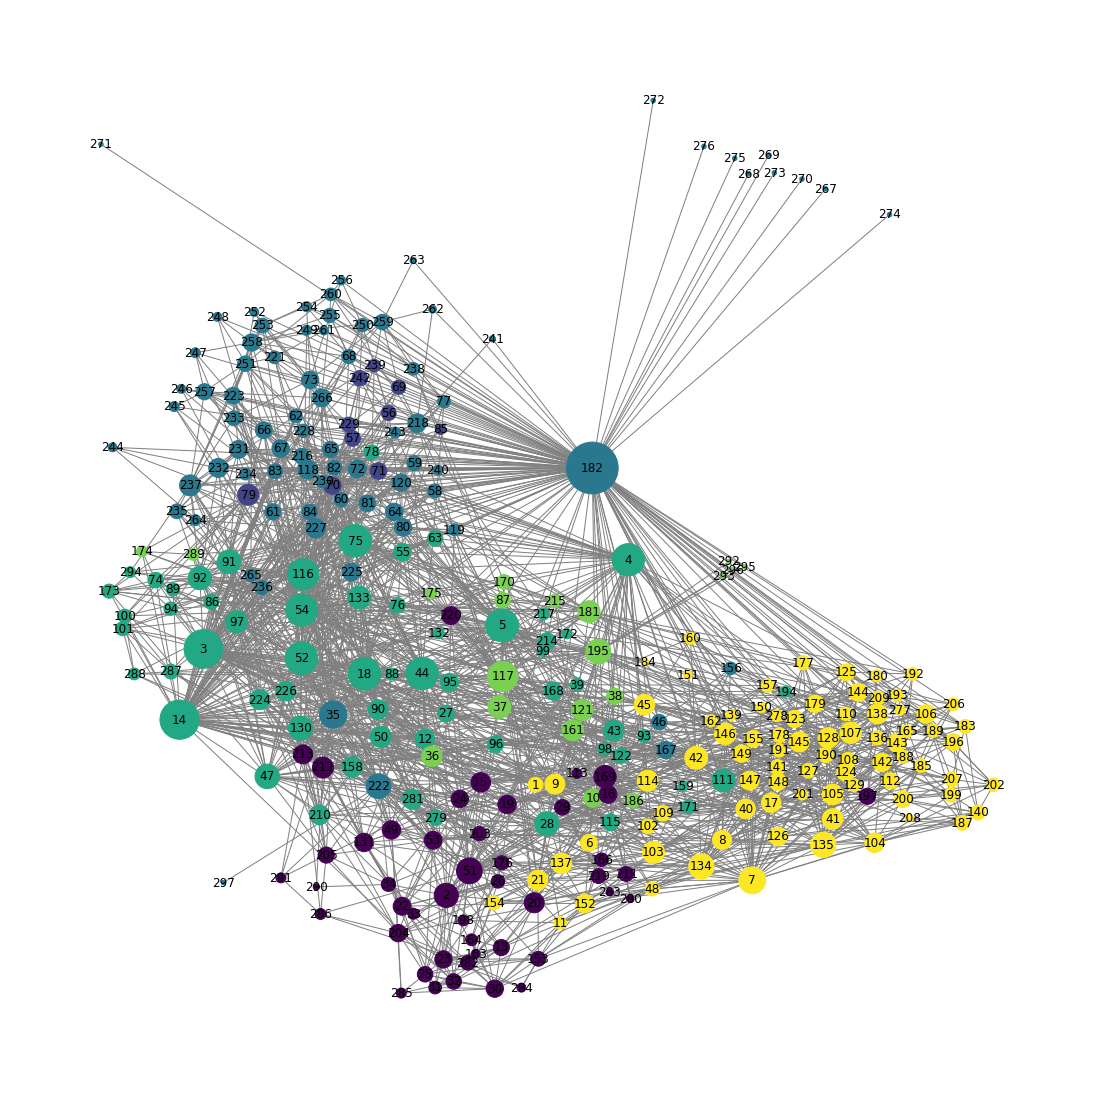

In [144]:

part_louvain = community.best_partition(G,weight='weight')
pos_louvain = forceatlas2.forceatlas2_networkx_layout(G,iterations=1000)
#forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)


plt.figure(figsize=(15,15))
node_weight = list(dict(G.degree()).values())

nx.draw(G, pos=pos_louvain, with_labels=True, node_color=list(part_louvain.values()),edge_color='grey',
       node_size=20*np.array(node_weight))


In [11]:
def multiscale_graph(G,res):
    partition = community.best_partition(G, resolution=res, weight='weight')
    sort_com = dict(sorted(partition.items(), key=lambda x: x[1]))#sort the partition
    
    #create a new graph
    Com_Gr = nx.Graph()
    
    #add nodes
    for node in sort_com.keys():
        Com_Gr.add_node(node)
        
    #add edges
    for s, e, w in G.edges(data=True):
        Com_Gr.add_edge(s, e, weight=w['weight'])
    
    return Com_Gr

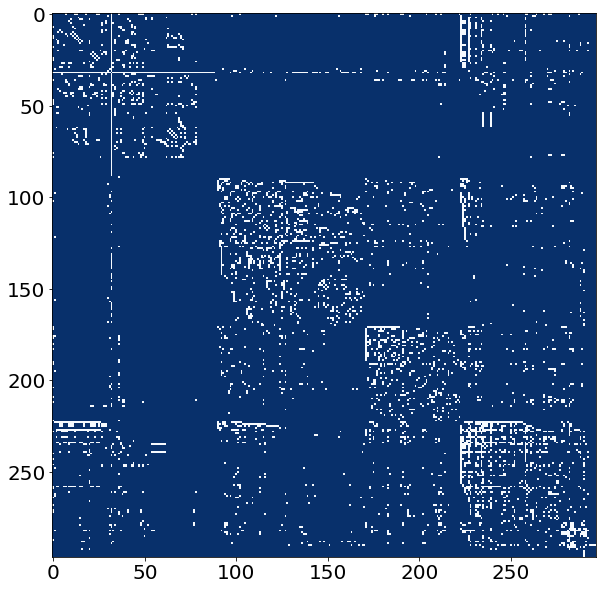

In [78]:
#Communities

louvain_graph = multiscale_graph(G,1.0,part_louvain)
lAd = nx.to_numpy_matrix(louvain_graph)
lAd = np.array(lAd.data)


plt.figure(figsize=(15,10))
plt.imshow(lAd, interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
plt.xticks(fontsize='20');plt.yticks(fontsize='20')
plt.show()

# Leiden Algorithm

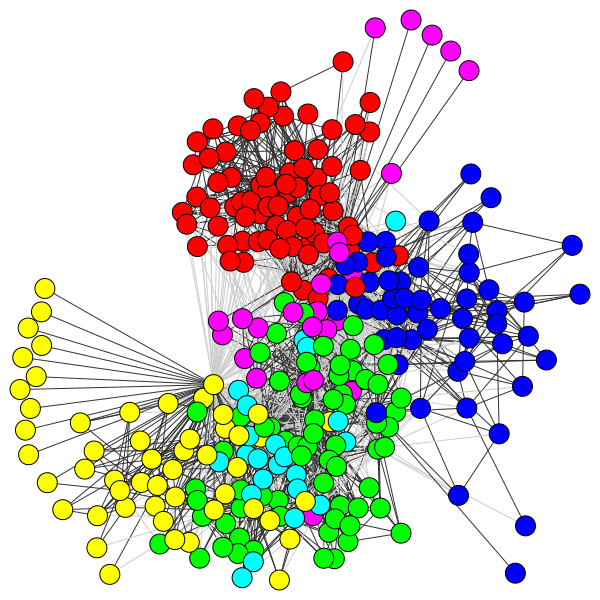

In [39]:
part_leiden = lalg.find_partition(iG, lalg.ModularityVertexPartition)
ig.plot(part_leiden)

In [38]:
def lei_multiscale(G,partition):
    new_iG = ig.Graph()
    for comm in partition:
        for node in comm:
            #print(node)
            new_iG.add_vertex(node)
    
    edge_list = G.get_edgelist()
    new_iG.add_edges(edge_list)
    return new_iG


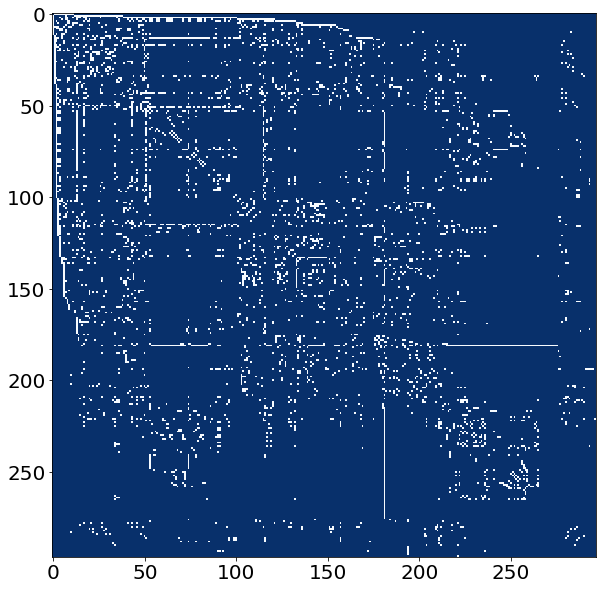

In [79]:
leiden_graph = lei_multiscale(iG,part_leiden)
lei_Ad = leiden_graph.get_adjacency()
lei_Ad = np.array(lei_Ad.data)

plt.figure(figsize=(15,10))
plt.imshow(lei_Ad,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
plt.xticks(fontsize='20');plt.yticks(fontsize='20')
plt.show()

In [ ]:
#curved_edges

# Produce the curves
# curves = curved_edges(G, positions)
# lc = LineCollection(curves, color='grey', alpha=0.05)
# plt.gca().add_collection(lc)
# plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 316.81it/s]


BarnesHut Approximation  took  0.03  seconds
Repulsion forces  took  0.11  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


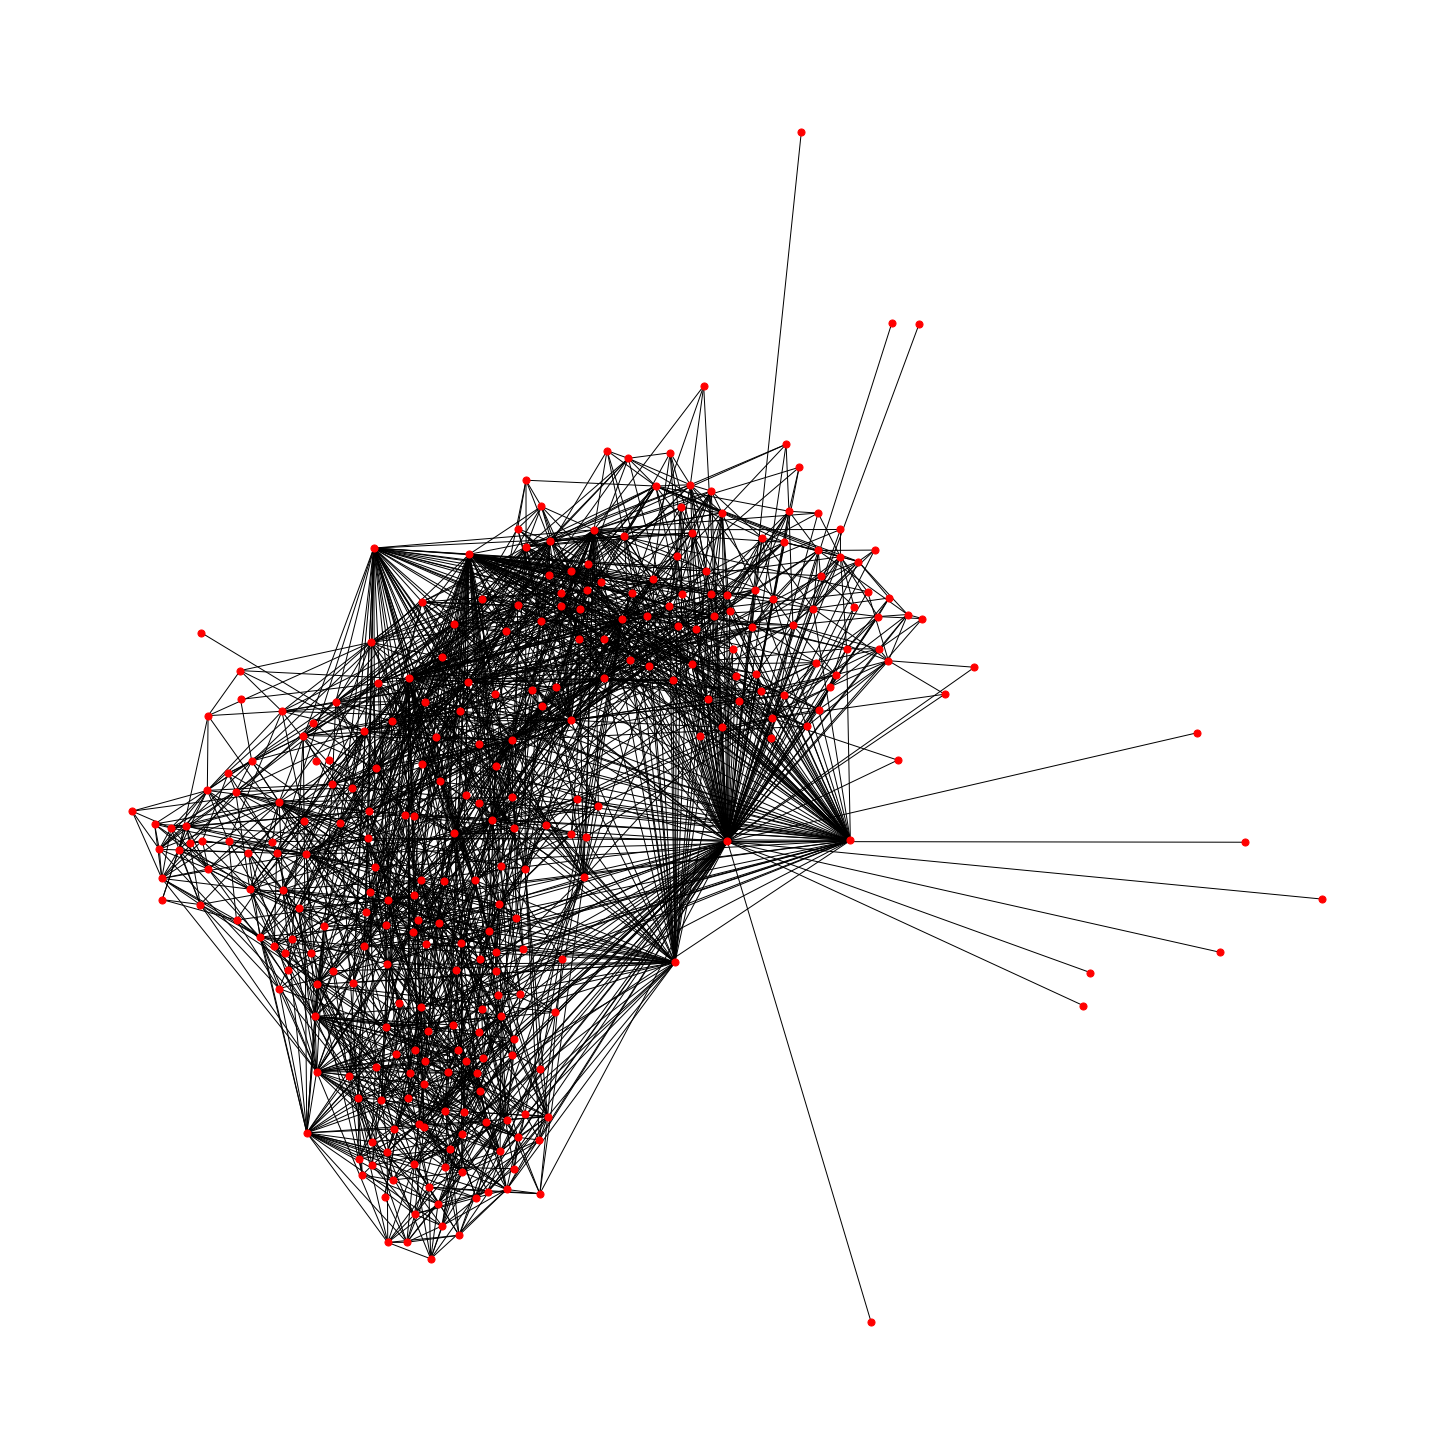

In [57]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

# Produce the curves
curves = curved_edges(G, positions)
lc = LineCollection(curves, color='#2f3f2f', alpha=0.05)

# Plot
plt.figure(figsize=(20,20))
nx.draw(G, positions, node_size=50, node_color='r', alpha=1.0)
#plt.gca().add_collection(lc)
#plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
plt.savefig('./Plots/atlaslayout.png')
plt.show()

# Multiscaling with Louvain algorithm

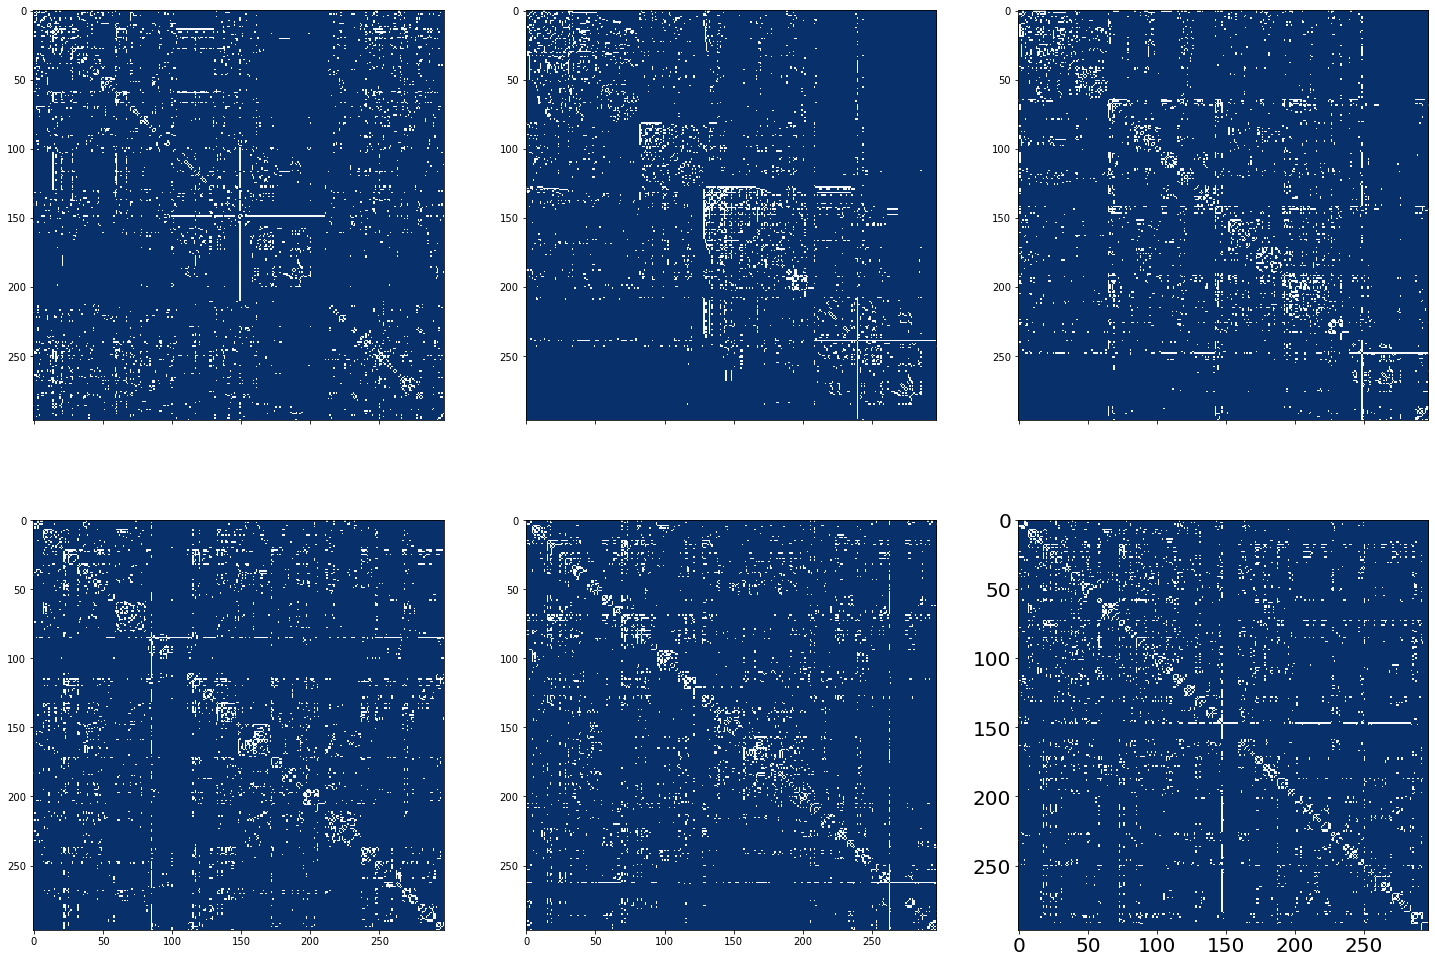

In [101]:
fig, axs = plt.subplots(2,3,figsize=(25,25), sharex=True);
#plt.setp(axes, fontsize=20)
fig.subplots_adjust(hspace=-.4)
#axs.xaxis.set_tick_params(labelbottom=True)
axs = axs.ravel();
res = np.arange(0.0,6.0);i=0
plt.xticks(fontsize='20');plt.yticks(fontsize='20');    

for r in res:
    Graph = multiscale_graph(G,r)
    Adj = nx.to_numpy_matrix(Graph)
    Adj = np.array(Adj)
    axs[i].imshow(Adj,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
    i+=1

plt.savefig('./Plots/multi_comm.png')
plt.show()

0.5026906286475119

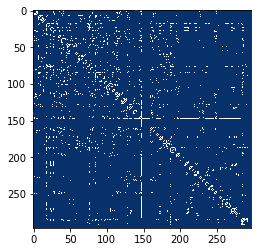

In [217]:
part2 = algorithms.leiden(G,weights='weight')
com = part2.communities

Com_Gr2 = nx.Graph()

for c in com:
    Com_Gr2.add_nodes_from(c)

for s,e,w in G.edges(data=True):
    Com_Gr2.add_edge(s,e,weight=w['weight'])
    
Com_Gr2.edges(data=True)

Adc = nx.to_numpy_matrix(Com_Gr2)
Adc = np.array(Adc)
plt.imshow(Adj,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))

nx.algorithms.community.modularity(G,com)

In [218]:
nx.algorithms.community.quality.partition_quality?

# LOUVAIN VS LEIDEN

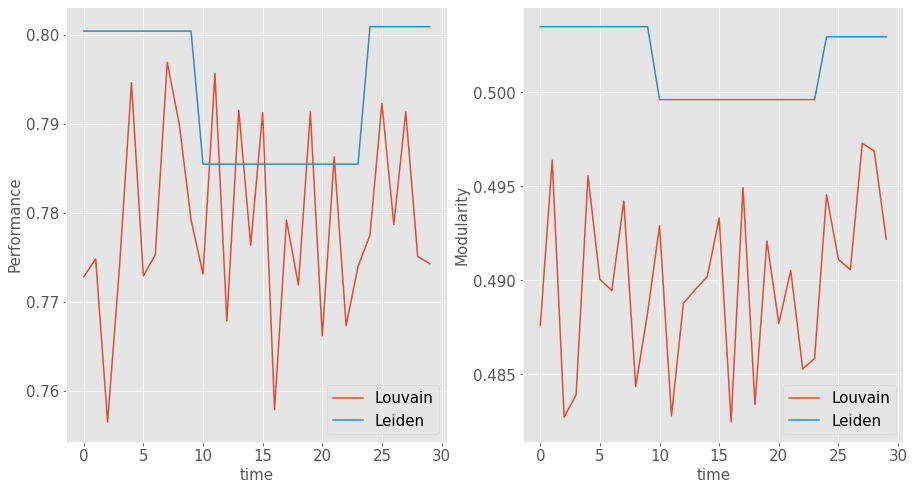

In [242]:
Lo = []; Le = [];#performance
Lo_mod = []; Le_mod=[]#modularity

for i in range(30):
    lo_com = algorithms.louvain(G,weight='weight').communities #Louvain community
    le_com = algorithms.leiden(G,weights='weight').communities #Leiden community
    
    #Performance
    lo_per = nx.algorithms.community.quality.partition_quality(G,lo_com)[1]
    le_per = nx.algorithms.community.quality.partition_quality(G,le_com)[1]
    
    #Modularity
    lo_mod = nx.algorithms.community.modularity(G,lo_com)
    le_mod = nx.algorithms.community.modularity(G,le_com)
    
    Lo.append(lo_per); Le.append(le_per)
    Lo_mod.append(lo_mod); Le_mod.append(le_mod)


plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(Lo,label='Louvain')
plt.plot(Le,label='Leiden')
plt.xticks(fontsize='15');plt.yticks(fontsize='15')
plt.xlabel('time',fontsize='15')
plt.ylabel('Performance',fontsize='15')
plt.legend(fontsize='15')

plt.subplot(122)
plt.xticks(fontsize='15');plt.yticks(fontsize='15')
plt.plot(Lo_mod,label='Louvain')
plt.plot(Le_mod,label='Leiden')
plt.xlabel('time',fontsize='15')
plt.ylabel('Modularity',fontsize='15')
plt.legend(fontsize='15')

plt.savefig('./Plots/louvainVSleiden.png')

Leiden have a higher perfomance value than Louvain. It is also more stable as opposed to the high volatility experienced in Louvain algorithm. You can be sure to have the same communities iteratively using Leiden algorithm, but Louvain does not guarantee that.

In [177]:
lo_com = algorithms.louvain(G,weight='weight').communities
nx.algorithms.community.quality.partition_quality(G,lo_com)

(0.5986964618249534, 0.7757075257075257)

In [143]:
algorithms.pa

0.4416600457312881

In [216]:
%timeit algorithms.leiden(G,weights='weight').communities

# %time algorithms.louvain(G,weight='weight').communities

14 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [159]:
lou_com = list(part_louvain.keys())
#nx.algorithms.community.modularity(G,lou_com)
sort_com = dict(sorted(part_louvain.items(), key=lambda x: x[1]))#sort the partition
lou_com

community.modularity(part_louvain,G,weight='weight')

0.4944333355135607